* Scatter plot for obs in October compared with extended river, reduced viscosity, reduced both viscosity and diffusivity cases for paper.

In [1]:
import os
import glob

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime

import sys
sys.path.append('/ocean/jieliu/research/meopar/analysis/Nancy/strat/comparisons/')
import comparisons

from salishsea_tools import tidetools, viz_tools,geo_tools
from nowcast import analyze

import seaborn as sns
from scipy import interpolate as interp

import ACTDR
import pandas as pd
%matplotlib inline

In [2]:
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [3]:
paths = {'RFdaily': '/data/jieliu/MEOPAR/IOS/octRFdaily/',
         '1e-05': '/data/jieliu/MEOPAR/IOS/oct1e05/',
          '1e-051e-06':'/data/jieliu/MEOPAR/IOS/oct1e061e05/'}
grid_B = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')    
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/mesh_mask.nc')
FIRST_NOWCAST = datetime.datetime(2014, 10,27)

In [22]:
def get_model_cast(year, month, day, data,lon,lat, field,model_path, cast):
    """Get the model daily mean, max and min corresponding to given year, month, day and lat/lon"""
    
    if field =='Salinity':
        var = 'vosaline'
    elif field == 'Temperature':
        var = 'votemper'
        
    date = datetime.datetime(year, month, day)
    data_m = data[data['Month'] == month]
    num_casts = len(data_m.index)
    bathy, X, Y= tidetools.get_bathy_data(grid_B)
    j, i = geo_tools.find_closest_model_point(lon, lat, X, Y, land_mask=bathy.mask)
    #print(j,i)
    filename_pattern = '1h_Plume{i}_T.nc'
    if j == 443 and i == 259:
        path = os.path.join(model_path, filename_pattern.format( i = 1))
    if j == 440 and i == 299:
        path = os.path.join(model_path, filename_pattern.format( i = 2))
    if j == 447 and i == 244:
        path = os.path.join(model_path, filename_pattern.format( i = 6))
    if j == 423 and i == 263:
        path = os.path.join(model_path, filename_pattern.format( i = 11))
    if j == 423 and i == 276:
        path = os.path.join(model_path, filename_pattern.format( i = 12))
    if j == 426 and i == 309:
        path = os.path.join(model_path, filename_pattern.format( i = 40))
        # print(j,i)
    ## for new result
    depths = mesh.variables['gdept'][0,:,j,i]
    new_file = nc.Dataset(path);
    var_model = new_file.variables[var][:,:,0,0]
    var_model, tmask = mask_model(j,i, var_model)
    # Daily mean/min/max
    min_daily = np.min(var_model[(day-1)*24:day*24,:], axis=0)
    max_daily = np.max(var_model[(day-1)*24:day*24,:], axis=0)
    mean_daily = np.mean(var_model[(day-1)*24:day*24,:], axis=0)

    return mean_daily, max_daily, min_daily, depths, tmask

In [5]:
def mask_model(j,i,var_model):
    """Mask a model variable at a grid point"""
    
    tmask = np.abs(1-mesh.variables['tmask'][:, :, j, i])
    tmask = tmask + np.zeros(var_model.shape)
    var_masked = np.ma.array(var_model, mask=tmask)
    return var_masked, tmask[0,:]

In [49]:
def prepare_cast_comparison(dep_obs, var_obs, year, month, day, lon, lat, cast,data,field,model_path):
    """Gather model and observed cast data for comparison"""
    
    # model data 
    mean_mod, max_mod, min_mod, dep_mod, tmask = get_model_cast(year, month, day, data,lon, lat,\
                                                        field, model_path,cast)
    #print(len(dep_obs),len(var_obs))
    # interp observations
    interp_obs = comparisons.interpolate_depth(var_obs, dep_obs, dep_mod)
    interp_obs = np.ma.array(interp_obs, mask=tmask)
    
    return interp_obs, mean_mod, max_mod, min_mod, dep_mod

In [7]:
ACTDR.load_dat('/ocean/jieliu/research/meopar/river-discharge/SOG_to.dat')

('> open ', '/ocean/jieliu/research/meopar/river-discharge/SOG_to.dat')
> load CTD_DAT
> load STANDARD_KEYS
('> close ', '/ocean/jieliu/research/meopar/river-discharge/SOG_to.dat')
> complete


In [8]:
data = pd.DataFrame(ACTDR.CTD_DAT)

data_fall = data[(data.Year>=2014) & (data.Month >=10) & (data.Month <12)]

In [9]:
import scipy.io as sio
rbr = sio.loadmat('/ocean/jieliu/research/meopar/surface current/rbr.mat')

value = rbr['a']

# Load three RBR into pandas frame

In [10]:
dep = [value[215:380,0].tolist()]
sal = [value[215:380,1].tolist()]
df1 = pd.DataFrame({'Day':2,'Depth':dep,'ID':20141002,'Latitude':49.1292,'Longitude':-123.2119,\
                                 'Month':10,'Salinity':sal,'Temperature':0,'Year':2014},index = ['2626']) #will work

In [11]:
dep2 = [value[569:422:-1,0].tolist()]
sal2 = [value[569:422:-1,1].tolist()]
df2 = pd.DataFrame({'Day':14,'Depth':dep2,'ID':20141014,'Latitude':49.1292,'Longitude':-123.2119,\
                                 'Month':10,'Salinity':sal2,'Temperature':0,'Year':2014},index = ['2627']) #will work

In [12]:
dep3 = [value[858:569:-1,0].tolist()]
sal3 = [value[858:569:-1,1].tolist()]
df3 = pd.DataFrame({'Day':29,'Depth':dep3,'ID':20141029,'Latitude':49.1292,'Longitude':-123.2119,\
                                 'Month':10,'Salinity':sal3,'Temperature':0,'Year':2014},index = ['2628']) #will work

In [13]:
data_fall = data_fall.append(df1)
data_fall = data_fall.append(df2)
data_fall = data_fall.append(df3)

In [14]:
month = 10
lon_min=-123.622
lon_max=-123.2
lat_min=49.
lat_max=49.19
data_region  = comparisons.isolate_region(data_fall,lon_min, lon_max, lat_min, lat_max)
data_m = data_region[data_region['Month'] == month] ## only extract oct no dec included
data_m = data_m.drop(2517) ## I found the label of that unwanted grid point in advance and drop it out

In [46]:
data_m

,Day,Depth,ID,Latitude,Longitude,Month,Salinity,Temperature,Year
2412,1,"[2.97450353215, 3.9659950894, 4.95748183682, 5...",20141001123534910,49.102667,-123.527000,10,"[26.0319, 26.0903, 26.3381, 26.7032, 27.3484, ...","[14.219, 14.2201, 14.2447, 14.0781, 13.5277, 1...",2014
2413,1,"[2.97448595822, 3.96597165755, 4.95745254708, ...",20141001123314917,49.167333,-123.310333,10,"[28.1933, 28.202, 28.5016, 29.0774, 29.211, 29...","[11.6249, 11.6694, 11.7502, 11.0351, 10.6856, ...",2014
2418,3,"[2.97450706575, 3.96599980086, 4.95748772612, ...",20141003123624909,49.089667,-123.620000,10,"[25.6417, 25.7952, 26.6898, 27.1377, 27.2564, ...","[15.0292, 14.9375, 14.2666, 13.9158, 13.8262, ...",2014
2515,28,"[2.97452328704, 3.96602142918, 4.95751476147, ...",20141028123444903,49.030000,-123.438500,10,"[20.1666, 19.7662, 19.7066, 19.7954, 21.7479, ...","[10.9279, 10.9136, 10.91, 10.914, 10.9987, 11....",2014
2516,28,"[1.98301586381, 2.97451658044, 3.96601248708, ...",20141028123374905,49.054667,-123.372667,10,"[18.8381, 22.033, 26.6084, 27.7956, 28.2945, 2...","[10.703, 10.7479, 10.9472, 10.9372, 10.8138, 1...",2014
2626,2,"[1.0166, 1.0946, 1.1807, 1.2679, 1.3475, 1.414...",20141002,49.129200,-123.211900,10,"[6.7119, 6.8207, 6.8846, 6.9424, 7.0098, 7.024...",0,2014
2627,14,"[1.0347, 1.1302, 1.2009, 1.2861, 1.3951, 1.478...",20141014,49.129200,-123.211900,10,"[7.004, 7.2087, 7.7385, 8.0143, 8.5943, 8.914,...",0,2014
2628,29,"[1.0088, 1.0724, 1.125, 1.1665, 1.1852, 1.2223...",20141029,49.129200,-123.211900,10,"[2.7635, 2.8609, 2.9307, 3.1692, 3.4452, 3.568...",0,2014


In [39]:
data_m[data_m.index=='2627'].Depth.values
#index = '2628'

array([ [1.0347, 1.1302, 1.2009, 1.2861, 1.3951, 1.4786, 1.5751, 1.6711, 1.7771, 1.8477, 1.9328, 2.0277, 2.1327, 2.2162, 2.2596, 2.3398, 2.4267, 2.5063, 2.5982, 2.6786, 2.7528, 2.7816, 2.8433, 2.9097, 2.9462, 3.0087, 3.0597, 3.134, 3.1846, 3.2539, 3.2996, 3.3809, 3.4242, 3.5022, 3.5472, 3.5971, 3.6268, 3.7039, 3.7459, 3.8495, 3.8688, 3.9642, 3.9901, 4.0794, 4.1277, 4.1915, 4.2174, 4.2714, 4.3203, 4.3481, 4.4009, 4.4272, 4.5035, 4.5242, 4.6023, 4.6285, 4.6949, 4.7195, 4.7941, 4.8376, 4.9063, 4.9165, 5.0004, 5.0894, 5.0977, 5.182, 5.2071, 5.2844, 5.3322, 5.4216, 5.4867, 5.5701, 5.622, 5.6883, 5.7617, 5.8631, 5.8845, 5.9896, 6.0271, 6.1722, 6.1784, 6.3364, 6.3811, 6.4783, 6.5224, 6.6499, 6.681, 6.7624, 6.8404, 6.9257, 7.0035, 7.0781, 7.1894, 7.2782, 7.3735, 7.4396, 7.575, 7.6177, 7.7251, 7.7866, 7.9622, 8.0232, 8.1599, 8.2383, 8.369, 8.4558, 8.5873, 8.6884, 8.8415, 8.9595, 9.0735, 9.239, 9.3751, 9.553, 9.6827, 9.8735, 9.9685, 10.1636, 10.2776, 10.461, 10.5983, 10.7841, 10.9544, 11.095, 11

In [56]:
def scatter_compare(data, month,field, cmin, cmax, model_path,ax, units):
    sal_flags=[]
    cast = 0
    for dep_obs, var_obs, lon, lat, year, day in zip(data['Depth'],
                                                        data[field],
                                                        data['Longitude'],
                                                        data['Latitude'],
                                                        data['Year'],
                                                        data['Day']):

        interp_obs, mean_mod, max_mod, min_mod, dep_mod = prepare_cast_comparison(dep_obs, var_obs,
                                            year, month, day,lon, lat, cast,data,field,model_path)
        thres=1; date=datetime.datetime(year, month, day)
        if field == 'Salinity':
            flag, k=classify_surface_salinity(interp_obs, mean_mod, max_mod, min_mod, thres)
            if flag == 0:
                print('Salinity within {} at depth {}, {}, {}, {}'.format(thres, dep_mod[k], lon, lat, date))
            if flag == 1:
                print('Too salty at depth {}, {}, {}, {}'.format(dep_mod[k], lon, lat, date))
            if flag == -1:
                print('Too fresh at depth {}, {}, {}, {}'.format(dep_mod[k], lon, lat, date))
            sal_flags.append(flag)
        ax.errorbar(interp_obs, mean_mod, yerr=[mean_mod-min_mod,max_mod-mean_mod ], fmt='k:',marker='', 
                         zorder=0, ecolor='gray',lw=1)
        sc = ax.scatter(interp_obs, mean_mod, marker='o', edgecolor='',c= dep_mod, 
                             norm=mcolors.LogNorm(), cmap='Spectral', vmin=0.5, vmax=300, s=50)
        ax.set_xlim([cmin, cmax])
        ax.set_ylim([cmin, cmax])
        ax.plot([cmin, cmax],[cmin, cmax], 'r-',zorder=0)
        cast = cast+1

    cb = plt.colorbar(sc, ax=ax)
    ticks = [1, 10, 25, 50, 100, 200, 400]
    cb.set_ticks(ticks)
    cb.set_ticklabels(ticks)
    cb.set_label('Depth [m]')
    ax.set_xlabel('Observed Practical {} '.format(field))
    ax.set_ylabel('Modelled Practical {} '.format(field))
    return sal_flags

In [53]:
def compare_region(data, month,lon_min, lon_max, lat_min, lat_max,model_path, title, smin=0, smax=32, tmin=8, tmax=16):
    cmapp = sns.diverging_palette(220, 20,as_cmap=True)
    data_region  = comparisons.isolate_region(data,lon_min, lon_max, lat_min, lat_max)
    data_m = data_region[data_region['Month'] == month] ## only extract oct no dec included
    data_m = data_m.drop(2517) ## I found the label of that unwanted grid point in advance and drop it out
    #sal
    fig2,(ax2,ax1) = plt.subplots(1,2,figsize = (16,6))
    field = 'Salinity'; 
    sal_flags=scatter_compare(data_m, month,field, smin,smax,model_path,ax2,'psu')
    #ax2.set_title('{} - {}'.format(title, field))
    #temp
    #fig3,ax3 = plt.subplots(1,1)
    #field = 'Temperature';
    #scatter_compare(data_m, month,field, tmin,tmax,model_path,ax3,'deg C')
    #ax3.set_title('{} - {}'.format(title, field))
    #map
    #fig1, ax1 = plt.subplots(1,1)
    ax1.scatter(data_m['Longitude'], data_m['Latitude'], s=50, c=sal_flags,cmap=cmapp,vmin=-1,vmax=1)
    viz_tools.plot_coastline(ax1,grid_B, coords='map')
    ax1.set_xlim([-124, -122.8])
    ax1.set_ylim([48.5, 49.4])
    ax1.set_title(title)
    return fig1, ax1

In [18]:
def classify_surface_salinity(interp_obs, mean_mod, max_mod, min_mod, thres):

    interp_obs = np.ma.masked_invalid(interp_obs)
    nonmasked = np.ma.flatnotmasked_edges(interp_obs)
    k=nonmasked[0]
    if (min_mod[k] -interp_obs[k] >thres) :
        flag = 1 #salty surface
    elif (max_mod[k] - interp_obs[k] )<-thres:
        flag = -1 #fresh surface
    else:
        flag =0  #ok
    
    return flag, k

In [41]:
def interpolate_depth(variable, depth_array, depth_new):
    """ interpolates a variable depth profile field to desire depth.
    Ideally the variable is already masked but this method masks invalid data.
    """
    # mask
    var_mask = np.ma.masked_invalid(variable)
    d_mask = np.ma.masked_invalid(depth_array)
    print(len(d_mask[~d_mask.mask]),len( var_mask[~var_mask.mask]))
    f = interp.interp1d(d_mask[~d_mask.mask], 
                        var_mask[~var_mask.mask],bounds_error=False)
    var_new = f(depth_new)
    
    return var_new

Too fresh at depth 3.50003051758, -123.527, 49.1026666667, 2014-10-01 00:00:00
Too fresh at depth 3.50003051758, -123.310333333, 49.1673333333, 2014-10-01 00:00:00
Salinity within 1 at depth 3.50003051758, -123.62, 49.0896666667, 2014-10-03 00:00:00
Too salty at depth 3.50003051758, -123.4385, 49.03, 2014-10-28 00:00:00
Too salty at depth 2.50001144409, -123.372666667, 49.0546666667, 2014-10-28 00:00:00
Salinity within 1 at depth 1.50000309944, -123.2119, 49.1292, 2014-10-02 00:00:00
Too salty at depth 1.50000309944, -123.2119, 49.1292, 2014-10-14 00:00:00
Too salty at depth 1.50000309944, -123.2119, 49.1292, 2014-10-29 00:00:00


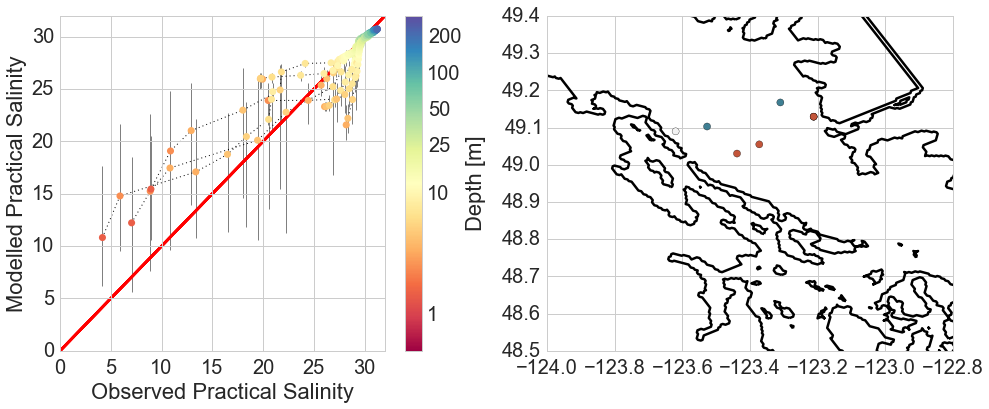

In [57]:
month = 10
lon_min=-123.622
lon_max=-123.2
lat_min=49.
lat_max=49.19
fig1,ax1 = compare_region(data_fall, month,lon_min, lon_max, lat_min, lat_max, paths['RFdaily'],'')

Too fresh at depth 3.50003051758, -123.527, 49.1026666667, 2014-10-01 00:00:00
Too fresh at depth 3.50003051758, -123.310333333, 49.1673333333, 2014-10-01 00:00:00
Salinity within 1 at depth 3.50003051758, -123.62, 49.0896666667, 2014-10-03 00:00:00
Too salty at depth 3.50003051758, -123.4385, 49.03, 2014-10-28 00:00:00
Salinity within 1 at depth 2.50001144409, -123.372666667, 49.0546666667, 2014-10-28 00:00:00
Salinity within 1 at depth 1.50000309944, -123.2119, 49.1292, 2014-10-02 00:00:00
Too salty at depth 1.50000309944, -123.2119, 49.1292, 2014-10-14 00:00:00
Too salty at depth 1.50000309944, -123.2119, 49.1292, 2014-10-29 00:00:00


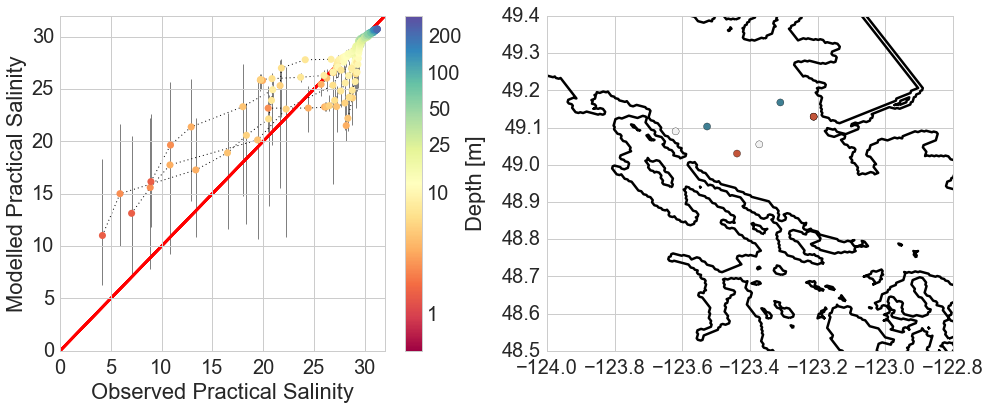

In [58]:
fig1,ax1 = compare_region(data_fall, month,lon_min, lon_max, lat_min, lat_max, paths['1e-05'],'')

Too fresh at depth 3.50003051758, -123.527, 49.1026666667, 2014-10-01 00:00:00
Too fresh at depth 3.50003051758, -123.310333333, 49.1673333333, 2014-10-01 00:00:00
Salinity within 1 at depth 3.50003051758, -123.62, 49.0896666667, 2014-10-03 00:00:00
Too salty at depth 3.50003051758, -123.4385, 49.03, 2014-10-28 00:00:00
Too salty at depth 2.50001144409, -123.372666667, 49.0546666667, 2014-10-28 00:00:00
Salinity within 1 at depth 1.50000309944, -123.2119, 49.1292, 2014-10-02 00:00:00
Too salty at depth 1.50000309944, -123.2119, 49.1292, 2014-10-14 00:00:00
Too salty at depth 1.50000309944, -123.2119, 49.1292, 2014-10-29 00:00:00


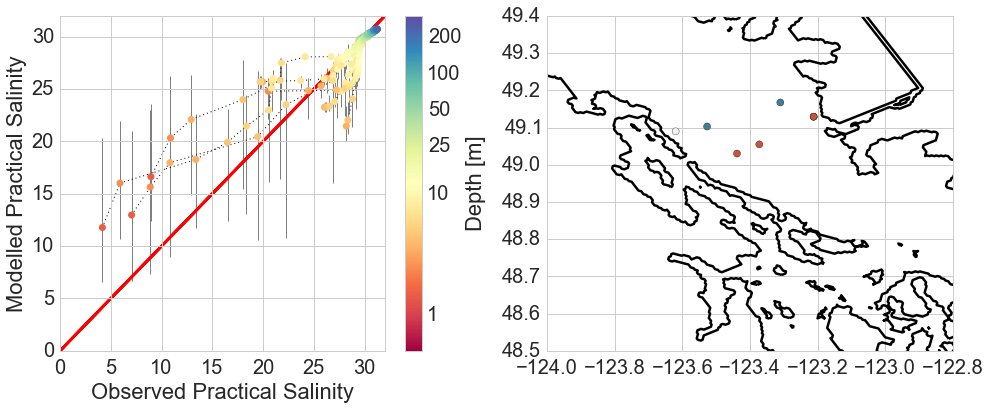

In [59]:
fig1,ax1 = compare_region(data_fall, month,lon_min, lon_max, lat_min, lat_max, paths['1e-051e-06'],'')